#### Import Libraries and Setup

In [2]:
#!/usr/bin/env python3
"""
Group 33, Florida Atlantic University
Fold Change Analysis for miRNA Expression in Cancer Stages
Date: 11/19/24
"""

import numpy as np
import pandas as pd
from pathlib import Path
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def load_mirna_data(file_path: str) -> pd.DataFrame:
    """
    Load and validate miRNA expression data from CSV file.
    
    Args:
        file_path (str): Path to the CSV file containing miRNA data
        
    Returns:
        pd.DataFrame: Loaded and validated miRNA data
    """
    try:
        data_path = Path(file_path)
        if not data_path.exists():
            raise FileNotFoundError(f"Data file not found: {file_path}")
            
        data = pd.read_csv(data_path)
        logging.info(f"Successfully loaded data from {file_path}")
        return data
        
    except Exception as e:
        logging.error(f"Error loading data: {str(e)}")
        raise

# Load the data
labeled_miRNA_data = load_mirna_data('../processed_data/miRNA_stage_subtype.csv')


2025-02-08 17:31:01,360 - INFO - Successfully loaded data from ../processed_data/miRNA_stage_subtype.csv


#### Data Preprocessing and Stage Aggregation

In [3]:
def calculate_stage_averages(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Calculate average expression values for healthy and cancer stages.
    
    Args:
        data (pd.DataFrame): Input miRNA expression data
        
    Returns:
        tuple: (stage_averages, negative_positive_averages)
    """
    # Exclude metadata columns and calculate mean by stage
    expression_cols = data.select_dtypes(include=[np.number]).columns
    stage_averages = data[expression_cols].groupby('stage').mean()
    
    # Separate healthy (stage 0) and cancer cases (stages 1+)
    healthy_cases = stage_averages.loc[[0]]
    cancer_cases = stage_averages.loc[stage_averages.index > 0]
    
    # Calculate average for all cancer stages
    cancer_average = cancer_cases.mean().to_frame().transpose()
    
    # Combine healthy and cancer averages
    negative_positive_averages = pd.concat(
        [healthy_cases, cancer_average],
        ignore_index=True
    ).transpose()
    
    negative_positive_averages.columns = ['healthy', 'cancer']
    
    return stage_averages, negative_positive_averages

# Calculate averages
stage_averages, neg_pos_averages = calculate_stage_averages(labeled_miRNA_data)


#### Fold Change Calculation

In [4]:
def calculate_log_fold_change(expression_data: pd.DataFrame, epsilon: float = 1e-4) -> pd.DataFrame:

    """
    Calculate log2 fold change between cancer and healthy samples.
    
    Args:
        expression_data (pd.DataFrame): DataFrame with healthy and cancer columns
        epsilon (float): Small value to avoid division by zero
        
    Returns:
        pd.DataFrame: Log2 fold changes for each miRNA
    """
    # Add epsilon to avoid division by zero
    adjusted_data = expression_data + epsilon
    
    # Calculate log2 fold change
    fold_changes = np.log2(adjusted_data['cancer'] / adjusted_data['healthy'])
    
    # Create DataFrame with results
    results = pd.DataFrame(
        fold_changes,
        columns=['log2_fold_change']
    )
    
    # Add metadata columns
    results['absolute_fold_change'] = abs(results['log2_fold_change'])
    results['regulation'] = np.where(
        results['log2_fold_change'] > 0,
        'upregulated',
        'downregulated'
    )
    
    return results.sort_values('absolute_fold_change', ascending=False)

# Calculate fold changes
fold_change_results = calculate_log_fold_change(neg_pos_averages)


#### Result Analysis and Visualization

In [5]:
def analyze_fold_changes(fold_change_df: pd.DataFrame, top_n: int = 10) -> dict:
    """
    Analyze fold change results and identify top regulated miRNAs.
    
    Args:
        fold_change_df (pd.DataFrame): DataFrame with fold change results
        top_n (int): Number of top regulated miRNAs to return
        
    Returns:
        dict: Dictionary containing analysis results
    """
    # Separate upregulated and downregulated miRNAs
    upregulated = fold_change_df[fold_change_df['log2_fold_change'] > 0]
    downregulated = fold_change_df[fold_change_df['log2_fold_change'] < 0]
    
    analysis_results = {
        'top_upregulated': upregulated.head(top_n),
        'top_downregulated': downregulated.head(top_n),
        'summary_stats': {
            'total_mirnas': len(fold_change_df),
            'upregulated_count': len(upregulated),
            'downregulated_count': len(downregulated),
            'max_fold_change': fold_change_df['log2_fold_change'].max(),
            'min_fold_change': fold_change_df['log2_fold_change'].min()
        }
    }
    
    return analysis_results

# Analyze results
analysis_results = analyze_fold_changes(fold_change_results)

# Display results
print("\nTop 10 most upregulated miRNAs in cancer patients:")
print(analysis_results['top_upregulated'][['log2_fold_change', 'regulation']])

print("\nTop 10 most downregulated miRNAs in cancer patients:")
print(analysis_results['top_downregulated'][['log2_fold_change', 'regulation']])

print("\nSummary Statistics:")
for key, value in analysis_results['summary_stats'].items():
    print(f"{key}: {value}")


Top 10 most upregulated miRNAs in cancer patients:
                log2_fold_change   regulation
hsa-mir-518f           15.479993  upregulated
subtype                13.808021  upregulated
hsa-mir-520e           13.290780  upregulated
hsa-mir-520d           13.166629  upregulated
hsa-mir-1283-2         12.642423  upregulated
hsa-mir-520h           12.495451  upregulated
hsa-mir-523            12.272183  upregulated
hsa-mir-519d           12.218065  upregulated
hsa-mir-515-2          11.849784  upregulated
hsa-mir-524            11.839949  upregulated

Top 10 most downregulated miRNAs in cancer patients:
              log2_fold_change     regulation
hsa-mir-571          -6.052735  downregulated
hsa-mir-4663         -6.025543  downregulated
hsa-mir-631          -4.137240  downregulated
hsa-mir-3907         -3.888020  downregulated
hsa-mir-1282         -3.625630  downregulated
hsa-mir-8085         -2.992225  downregulated
hsa-mir-3937         -2.910867  downregulated
hsa-mir-663b        

### Stage-Specific Analysis

In [6]:
def analyze_stage_specific_changes(data: pd.DataFrame, stage_averages: pd.DataFrame, epsilon: float = 1e-4) -> pd.DataFrame:

    """
    Calculate fold changes for each cancer stage separately.
    
    Args:
        data (pd.DataFrame): Original miRNA expression data
        stage_averages (pd.DataFrame): Average expression by stage
        epsilon (float): Small value to avoid division by zero
        
    Returns:
        pd.DataFrame: Stage-specific fold changes
    """
    # Get healthy (stage 0) expression
    healthy_expression = stage_averages.loc[0]
    
    # Initialize results dictionary
    stage_results = {}
    
    # Calculate fold changes for each cancer stage
    for stage in stage_averages.index[1:]:  # Skip stage 0
        stage_expression = stage_averages.loc[stage]
        
        # Calculate log2 fold change
        fold_changes = np.log2(
            (stage_expression + epsilon) / (healthy_expression + epsilon)
        )
        
        stage_results[f'stage_{stage}'] = fold_changes
    
    # Combine results into DataFrame
    stage_specific_changes = pd.DataFrame(stage_results)
    
    return stage_specific_changes

# Calculate stage-specific fold changes
stage_specific_results = analyze_stage_specific_changes(
    labeled_miRNA_data,
    stage_averages
)

# Print results (based on Tremayne's suggestion)
print("\nStage-Specific Log2 Fold Changes:")
print(stage_specific_results.head())  # Show first few rows


Stage-Specific Log2 Fold Changes:
               stage_1   stage_2   stage_3   stage_4
hsa-let-7a-1  0.108234  0.085668  0.112585 -0.016215
hsa-let-7a-2  0.113605  0.091411  0.117074 -0.012778
hsa-let-7a-3  0.108118  0.085507  0.111301 -0.018098
hsa-let-7b    0.186361  0.216619  0.127953  0.165120
hsa-let-7c   -0.251983 -0.327775 -0.385766 -0.452331


#### Export Results

In [ ]:
def export_results(
    fold_changes: pd.DataFrame,
    stage_specific: pd.DataFrame,
    output_dir: str = '../results'
) -> None:
    """
    Export analysis results to CSV files.
    
    Args:
        fold_changes (pd.DataFrame): Overall fold change results
        stage_specific (pd.DataFrame): Stage-specific fold changes
        output_dir (str): Directory for output files
    """
    # Create output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Export overall fold changes
    fold_changes.to_csv(
        output_path / 'fold_change_results.csv',
        index=True
    )
    
    # Export stage-specific results
    stage_specific.to_csv(
        output_path / 'stage_specific_fold_changes.csv',
        index=True
    )
    
    logging.info(f"Results exported to {output_dir}")

# Export all results
export_results(fold_change_results, stage_specific_results)

print("\nAnalysis complete. Results have been exported to the results directory.")

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

2025-02-08 17:31:12,506 - INFO - Results exported to ../results



Analysis complete. Results have been exported to the results directory.


#### Visualization

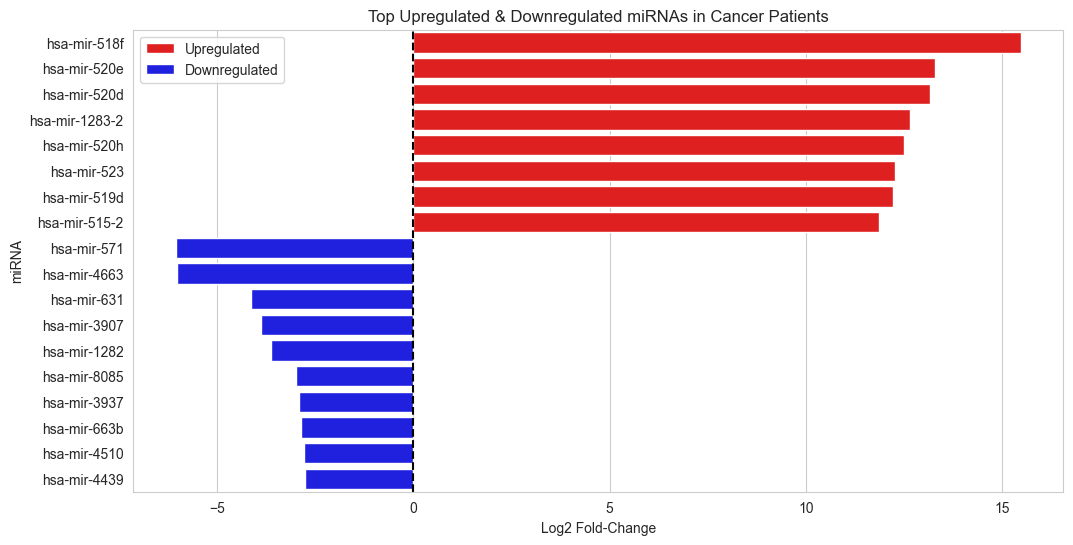

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out non-miRNA entries
top_upregulated = analysis_results['top_upregulated'].drop(index=['subtype', 'stage'], errors='ignore')
top_downregulated = analysis_results['top_downregulated'].drop(index=['subtype', 'stage'], errors='ignore')

# Set figure size
plt.figure(figsize=(12, 6))

# Create horizontal bar plots
sns.barplot(
    x=top_upregulated["log2_fold_change"], 
    y=top_upregulated.index, 
    color='red', 
    label="Upregulated"
)

sns.barplot(
    x=top_downregulated["log2_fold_change"], 
    y=top_downregulated.index, 
    color='blue', 
    label="Downregulated"
)

# Add vertical reference line at 0
plt.axvline(x=0, color='black', linestyle='--')

# Labels & title
plt.xlabel("Log2 Fold-Change")
plt.ylabel("miRNA")
plt.title("Top Upregulated & Downregulated miRNAs in Cancer Patients")
plt.legend()

# Show the plot
plt.show()